## Overview:
    This project will help me better understand how specific characteristics of songs, like energy, popularity, tempo, and more can be used to predict a song's genre.

# Main Research Question: 
    Using the display_basic_info, empty_rows, and plot_heatmap methods, we will better understand the dataset and the characteristics of instances that could determine the genre of songs.

# Part One
    Basic importing and visualization of data using pie charts and heatmaps

In [269]:
import pandas as pd #to use dataframe functions
import numpy as np #for numerical operations like max/min
import matplotlib.pyplot as plt #used for graphing
import seaborn as sns #for heatmap and plots

In [163]:
class BaseVisualizer:
    def __init__(self, df):
        self.df = df

    def display_basic_info(self):
        ''' display essential and basic dataset info '''
        print(f'Basic Data Statistics: \n{self.df.describe()}')
        print(f'\nRows, Columns: {self.df.shape}') #'Class' column in the train dataset classifies the genre
        print(f'\nFirst Five Rows: {self.df.head()}')
        print(f'\nMissing values per column:\n{self.df.isnull().sum()}')
        print(f'\nDtypes:\n{self.df.dtypes}')
        
        min_genre = np.min(self.df['Class'])
        max_genre = np.max(self.df['Class'])
        print(f'\nNumber of genres: {(max_genre - min_genre) + 1}')#+1 accounting for if min index value is 0

    def empty_rows(self, columns):
        ''' Find and replace any empty rows with the mean '''
        empty_counts = {}
        for column in columns:
            num_missing = self.df[column].isnull().sum()
            self.df[column] = self.df[column].fillna(self.df[column].mean()) #used mean to fill the value instead of 0
            empty_counts[column] = num_missing

        print("Filled missing values:")
        for col, count in empty_counts.items():
            print(f" - {col}: {count} missing values filled")

        print(f"\nRemaining missing values:\n{self.df[columns].isnull().sum()}")

    def plot_genre_distribution(self):
        '''Plot a pie chart showing the distribution of genres.'''
        if 'Class' not in self.df.columns:
            print("Column 'Class' not found.")
            return
        
        number_to_genre = {
            0: '0: Acoustic/Folk', 1: '1: Alt', 2: '2: Blues',
            3: '3: Bollywood', 4: '4: Country', 5: '5: Hip Hop',
            6: '6: Indie', 7: '7: Instrumental', 8: '8: Metal',
            9: '9: Pop', 10: '10: Rock'
        }
        # Map class numbers to genre names
        genre_counts = self.df['Class'].value_counts().sort_index()
        genre_labels = [number_to_genre[i] for i in genre_counts.index]
        colors = plt.get_cmap('tab20')(np.linspace(0, 1, len(genre_counts))) #default colors repeat, originally leaving the same color next to eachother
        
        # plotting pie chart of distribution of genres
        plt.figure(figsize=(10, 10))
        patches, texts, autotexts = plt.pie(
            genre_counts,
            autopct='%1.1f%%',
            colors=colors
        )
        plt.title('Genre Distribution')
        plt.legend(patches, genre_labels, loc='center right', title='Genres')
        plt.ylabel('') # to remove the 'Class' label from side
        plt.show()
        
    def plot_heatmap(self):
        ''' plot heatmap of dataset to compare similarity between features'''
        plt.figure(figsize=(12, 6))
        sns.heatmap(self.df.drop('Class', axis=1).corr(), annot=True, cmap='coolwarm', fmt='.2f')
        plt.title('Correlation Heatmap of Features')
        plt.show()

### Outputs and visualizing dataset

Basic Data Statistics: 
         Popularity  danceability        energy           key      loudness  \
count  17568.000000  17996.000000  17996.000000  15982.000000  17996.000000   
mean      44.512124      0.543433      0.662777      5.952447     -7.910660   
std       17.426928      0.166268      0.235373      3.196854      4.049151   
min        1.000000      0.059600      0.000020      1.000000    -39.952000   
25%       33.000000      0.432000      0.509000      3.000000     -9.538000   
50%       44.000000      0.545000      0.700000      6.000000     -7.016000   
75%       56.000000      0.659000      0.860000      9.000000     -5.189000   
max      100.000000      0.989000      1.000000     11.000000      1.355000   

               mode   speechiness  acousticness  instrumentalness  \
count  17996.000000  17996.000000  17996.000000      13619.000000   
mean       0.636753      0.079707      0.247082          0.177562   
std        0.480949      0.083576      0.310632          

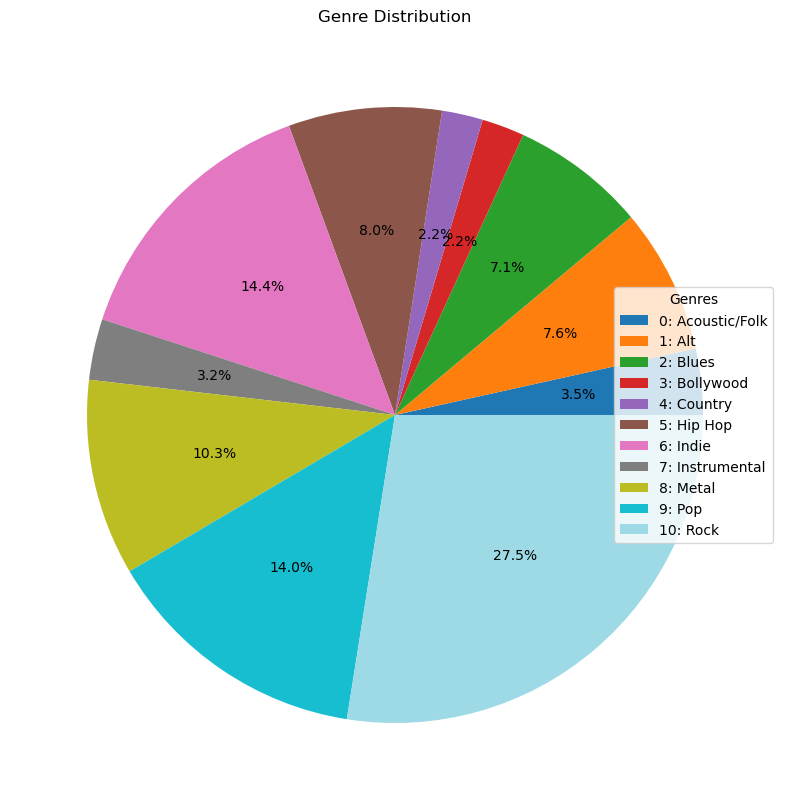

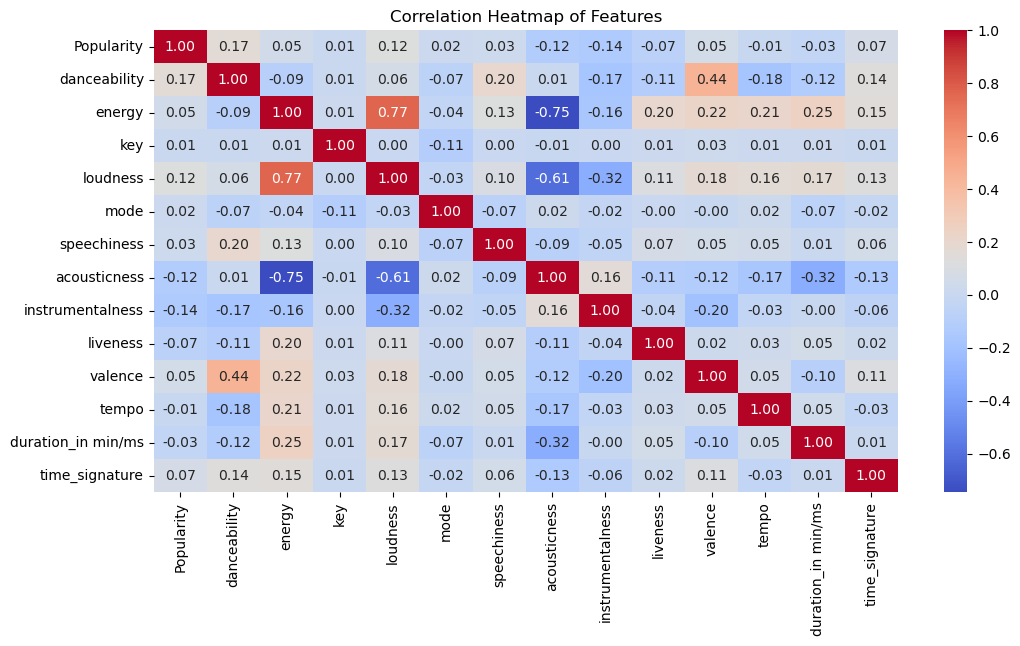

In [347]:
# load and preprocess the dataset
df = pd.read_csv('train.csv')
#df.head()
df.drop(['Artist Name', 'Track Name'], axis=1, inplace=True) #remove nonnumerical columns

# stats of data
base_visualizer = BaseVisualizer(df)
base_visualizer.display_basic_info()
base_visualizer.empty_rows(['Popularity', 'key', 'instrumentalness']) #rows that were mentioned with missing values
base_visualizer.plot_genre_distribution()
base_visualizer.plot_heatmap()

### Observations
##### Features that have strong correlations (correlation>0.4):
##### Positive Correlation:
    Loudness and Energy (0.768)
    Valence and Dancability (0.445)
##### Negative Correlation:
    Acousticness and Energy (-0.746)
    Acousticness and Loudness(-0.613)
##### Heatmap: Noticed that popularity isnt determined greatly by just one element of a song.

# Part 2
    For my dataset, I wanted to find the best parameterization values to use for later evaluation of my dataset.

In [275]:
from sklearn.model_selection import train_test_split #splitting dataset: training and testing
from sklearn.neighbors import KNeighborsClassifier # used to evaluate K-NN
from sklearn.metrics import accuracy_score, confusion_matrix #used to calculate accuracy of classification

In [295]:
class GenreModelTester(BaseVisualizer):
    def __init__(self, df):
        self.X = df.drop('Class', axis=1)
        self.y = df['Class']
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.3, random_state=42) #use 30% of dataset for testing, other goes to training

    def evaluate_knn(self, neighbors_list):
        scores = [] # so all param values/accuracy are in one array
        for k in neighbors_list:
            model = KNeighborsClassifier(n_neighbors=k) #using KNN as model to test
            model.fit(self.X_train, self.y_train)#fitting the model based on the training data
            y_pred = model.predict(self.X_test) # find the predicted y values of the other 30% of data
            acc = accuracy_score(self.y_test, y_pred)
            scores.append(acc)
            print(f'K={k}, Accuracy: {acc:.4f}')
        self.plot_accuracy(neighbors_list, scores, 'K-Nearest Neighbors')
    
    def evaluate_rf(self, estimators_list):
        scores = []
        for n in estimators_list:
            model = RandomForestClassifier(n_estimators=n) #using Random Forest as model to test
            model.fit(self.X_train, self.y_train) 
            y_pred = model.predict(self.X_test) 
            acc = accuracy_score(self.y_test, y_pred)
            scores.append(acc)
            print(f'Estimators={n}, Accuracy: {acc:.4f}')
        self.plot_accuracy(estimators_list, scores, 'Random Forest')

    def plot_accuracy(self, x_values, acc_scores, title):
        plt.figure(figsize=(12, 5))
        plt.plot(x_values, acc_scores, marker='o', linestyle='--')
        plt.title(f'{title} Hyperparameterization')
        plt.xlabel('Parameter Value')
        plt.ylabel('Accuracy')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

K=1, Accuracy: 0.2078
K=10, Accuracy: 0.2763
K=25, Accuracy: 0.2999
K=50, Accuracy: 0.3219
K=100, Accuracy: 0.3254
K=200, Accuracy: 0.3243


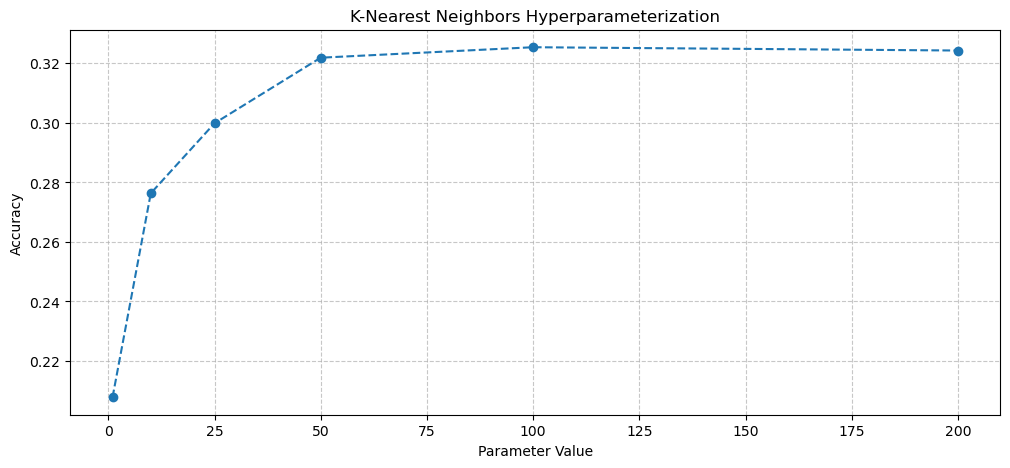

Estimators=50, Accuracy: 0.5101
Estimators=100, Accuracy: 0.5101
Estimators=200, Accuracy: 0.5127
Estimators=400, Accuracy: 0.5153
Estimators=600, Accuracy: 0.5112


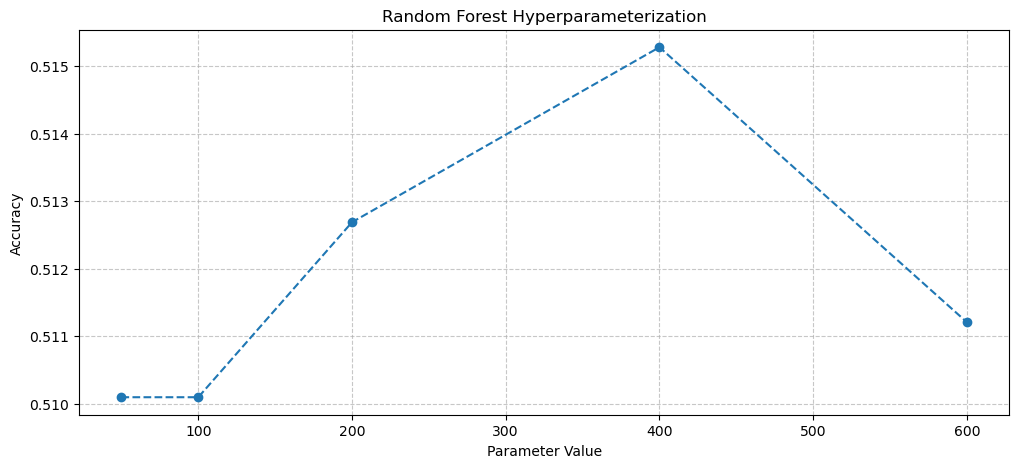

In [297]:
# evaluating at different param values
genre_model_testing = GenreModelTester(df)
genre_model_testing.evaluate_knn([1, 10, 25, 50, 100, 200])
genre_model_testing.evaluate_rf([50, 100, 200, 400, 600])

### Observations
    Random Forest is more accurate, as it sits around 50% accuracy and K-NN sits around 30%. Random Forest takes more computation time, however, the 20% extra accuracy is worth the extra 5 second wait time.
    Random Forest is better for dealing with outliers, while K-NN isnt. This demonstrates that the dataset either has a lot of outliers, or there isn't a strong correlation between single characteristics of songs and genre classification.

# Part 3
    I compared different classification models to test classifying the songs into the correct genres. Using models recommended in-class, I tested the accuracy and also used feature importance to analyze the features of songs.

In [332]:
from sklearn.linear_model import LogisticRegression # machine learning model to compare
from sklearn.svm import SVC # machine learning model to compare, svm:support vector machines
from xgboost import XGBClassifier # machine learning model to compare
from sklearn.preprocessing import StandardScaler # machine learning model to compare
from sklearn.pipeline import make_pipeline # simplifies scaling preprocessing and model fitting.
from tabulate import tabulate #format and display results of model comparisons in a readable table.

class GenreClassifier(BaseVisualizer):
    def __init__(self, df):
        self.X = df.drop('Class', axis=1)
        self.y = df['Class']
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.3, random_state=42)

    def compare_classifiers(self):
        classifiers = {
            "K-NN (k=100)": KNeighborsClassifier(n_neighbors=100),
            "Random Forest (n=100)": RandomForestClassifier(n_estimators=100, random_state=42),
            "Logistic Regression": make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
            "SVM": make_pipeline(StandardScaler(), SVC(kernel='rbf')),
            "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')}

        results = []
        for name, clf in classifiers.items():
            clf.fit(self.X_train, self.y_train)
            pred = clf.predict(self.X_test)
            acc = accuracy_score(self.y_test, pred)
            results.append((name, acc))

        print('\nClassifier Accuracy Comparison:\n')
        print(tabulate(results, headers=['Classifier', 'Accuracy'], floatfmt='.4f')) #using tabulate to format tabl
    
    def plot_accuracy(self, x_vals, acc_scores, title):
        plt.figure(figsize=(12, 5))
        plt.plot(x_vals, acc_scores, marker='o', linestyle='--')
        plt.title(f'{title} Accuracy vs Hyperparameter')
        plt.xlabel('Parameter Value')
        plt.ylabel('Accuracy')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

    def plot_feature_importance(self):
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_model.fit(self.X_train, self.y_train)

        xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
        xgb_model.fit(self.X_train, self.y_train)
        
        feature_names = self.X.columns #for y-labels
    # importance values for rf and xgb (knn is distance-based model)
        rf_importances = rf_model.feature_importances_
        xgb_importances = xgb_model.feature_importances_
    # subplot
        fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
    # random forest
        rf_sorted_idx = rf_importances.argsort()
        axes[0].barh(range(len(rf_sorted_idx)), rf_importances[rf_sorted_idx], color='skyblue')
        axes[0].set_yticks(range(len(rf_sorted_idx)))
        axes[0].set_yticklabels(feature_names[rf_sorted_idx])
        axes[0].set_title("Random Forest Feature Importance")
    # xgb
        xgb_sorted_idx = xgb_importances.argsort()
        axes[1].barh(range(len(xgb_sorted_idx)), xgb_importances[xgb_sorted_idx], color='salmon')
        axes[1].set_yticks(range(len(xgb_sorted_idx)))
        axes[1].set_yticklabels(feature_names[xgb_sorted_idx])
        axes[1].set_title("XGBoost Feature Importance")

        plt.tight_layout()
        plt.show()

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:43:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classifier Accuracy Comparison:

Classifier               Accuracy
---------------------  ----------
K-NN (k=100)               0.3254
Random Forest (n=100)      0.5069
Logistic Regression        0.4892
SVM                        0.5312
XGBoost                    0.5166


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:43:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


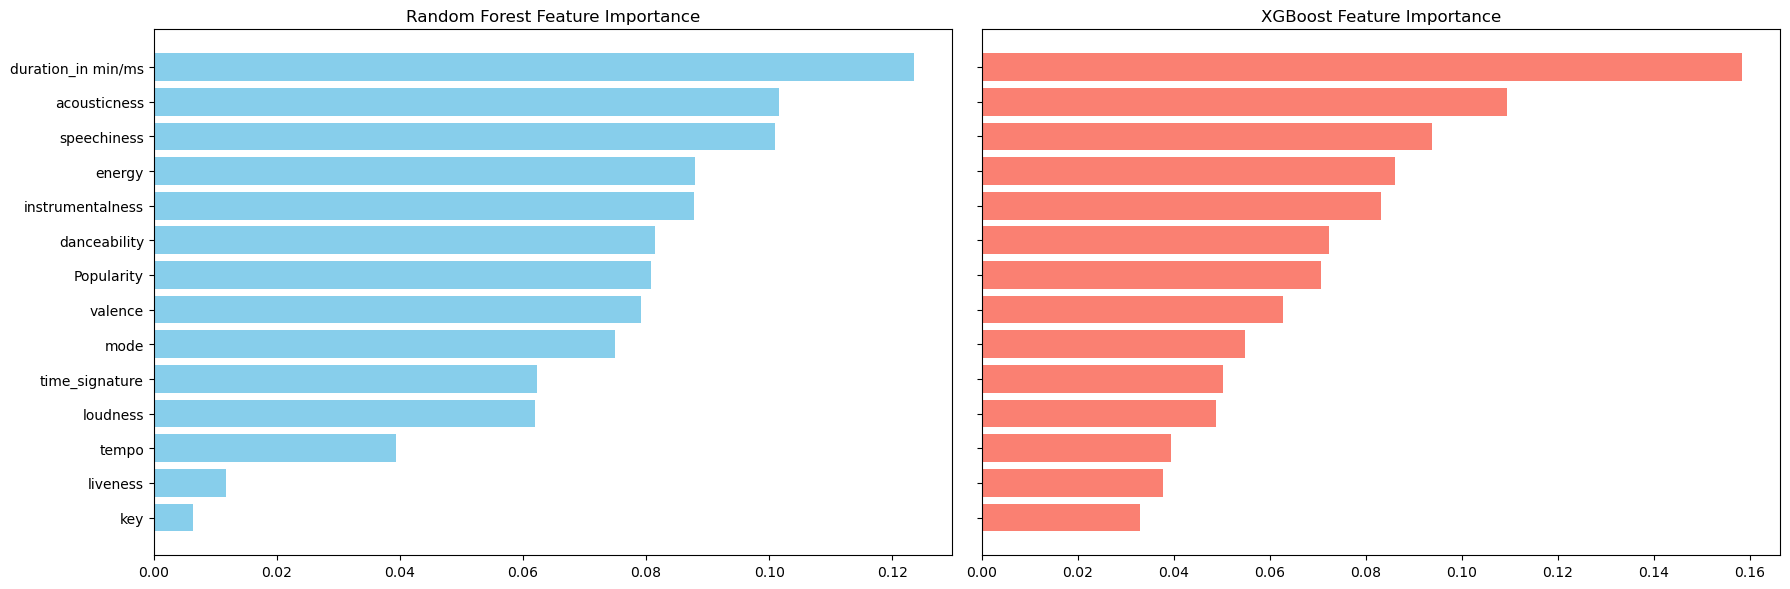

In [334]:
#running the code
genre_classifier = GenreClassifier(df)
genre_classifier.compare_classifiers()
genre_classifier.plot_feature_importance()

# Observations
    Used the previous part, I put in the most effective parameters into K-NN and Random Forest.
    I noticed that most of the models, except K-NN, sit around 50% accuracy. This confirms my belief that genre classification is difficult since there aren't distinct rules for each genre. There are a lot of overlapping features between genres.
    Also, the feature importance graphs show that duration, acousticness, speechiness are the 3 most important features that influence the models decision to classify a song as a specifc genre.

# Part 4
    I was curious to see if I used KMeans to group the data into 11 clusters (representitive of the number of genres in the dataset). Would it be accurate and have the same genre distribution?

In [280]:
from sklearn.cluster import KMeans # for clustering songs based on data features

In [227]:
class ClusterVisualizer(BaseVisualizer):
    def __init__(self, df):
        self.df = df

    def plot_clusters(self, x_features, k=11, iterations=100):
        X = self.df[x_features].values
        kmeans = KMeans(n_clusters=k, max_iter=iterations, init='k-means++', n_init='auto', random_state=42)
        labels = kmeans.fit_predict(X)
        centroids = kmeans.cluster_centers_

        # Scatter plot
        plt.figure(figsize=(10, 8))
        plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, alpha=0.6)
        plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X')
        plt.title(f'K-Means Clustering for {x_features[0]} and {x_features[1]} (k={k})')
        plt.xlabel(x_features[0])
        plt.ylabel(x_features[1])
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

        # pie chart plotting
        unique, counts = np.unique(labels, return_counts=True)
        plt.figure(figsize=(8, 8))
        plt.pie(counts, labels=[f'Cluster {i}' for i, count in zip(unique, counts)], autopct='%1.1f%%',
            startangle=140, colors=plt.get_cmap('tab20')(np.linspace(0, 1, k)))
        plt.title(f'Cluster Distribution for {x_features[0]} and {x_features[1]}')
        plt.show()

### Outputs for cluster visulization
    I decided to plot the most correlated variables to cluster. 

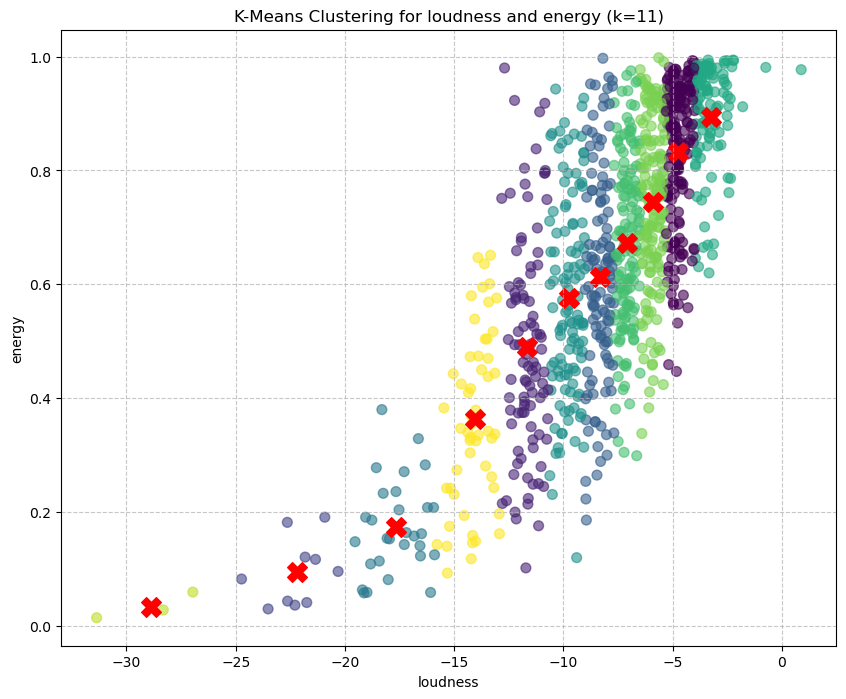

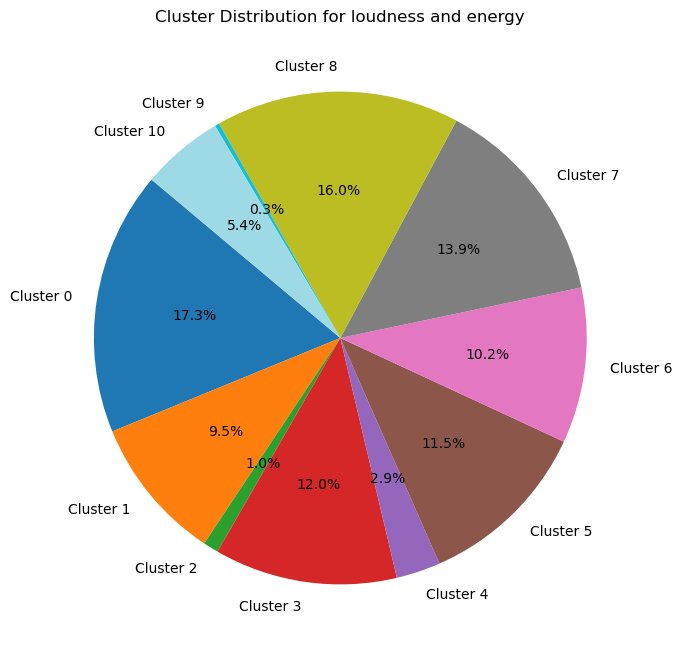

In [246]:
# Clustering (first 1000 rows for simplicity)
cluster_visualizer = ClusterVisualizer(df.head(1000))

cluster_visualizer.plot_clusters(['loudness', 'energy'], k=11)

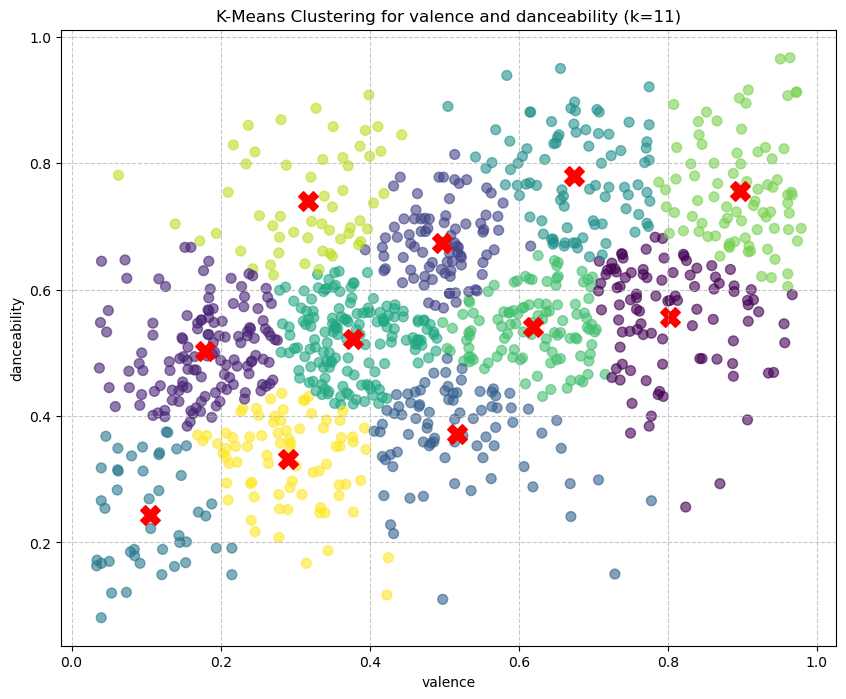

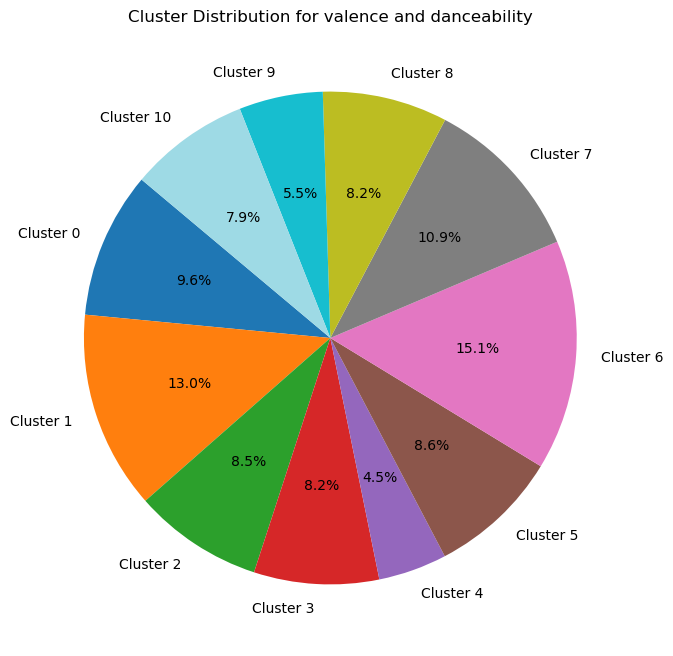

In [231]:
cluster_visualizer.plot_clusters(['valence', 'danceability'], k=11)

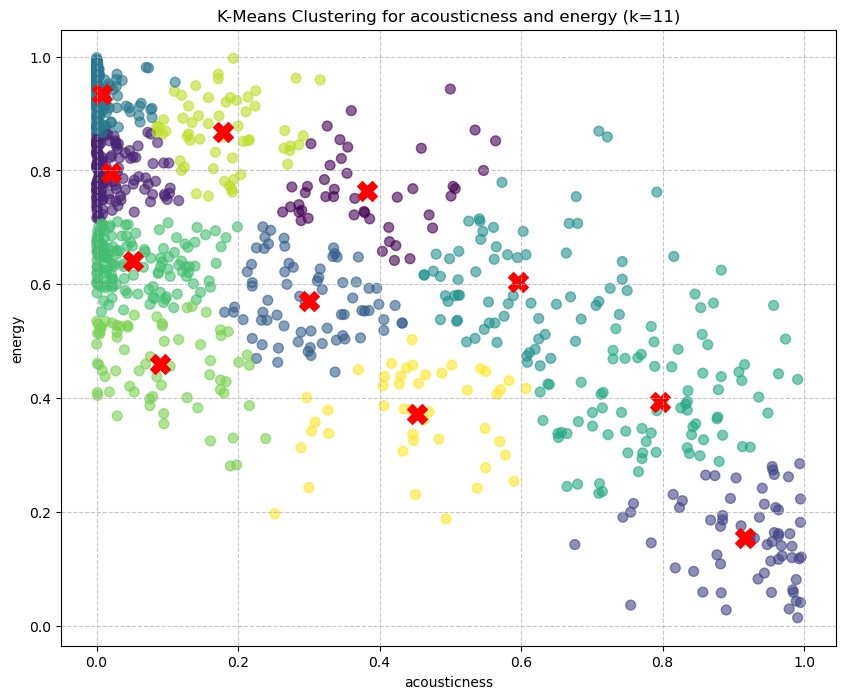

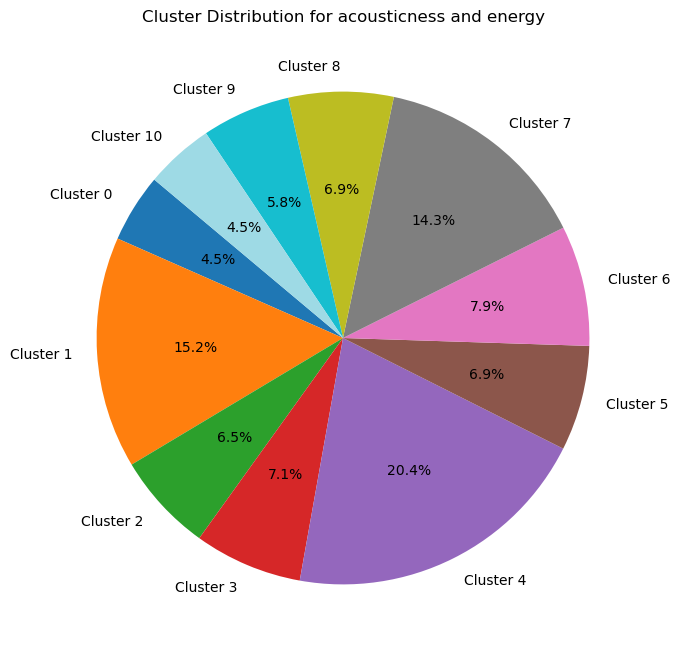

In [233]:
cluster_visualizer.plot_clusters(['acousticness', 'energy'], k=11)

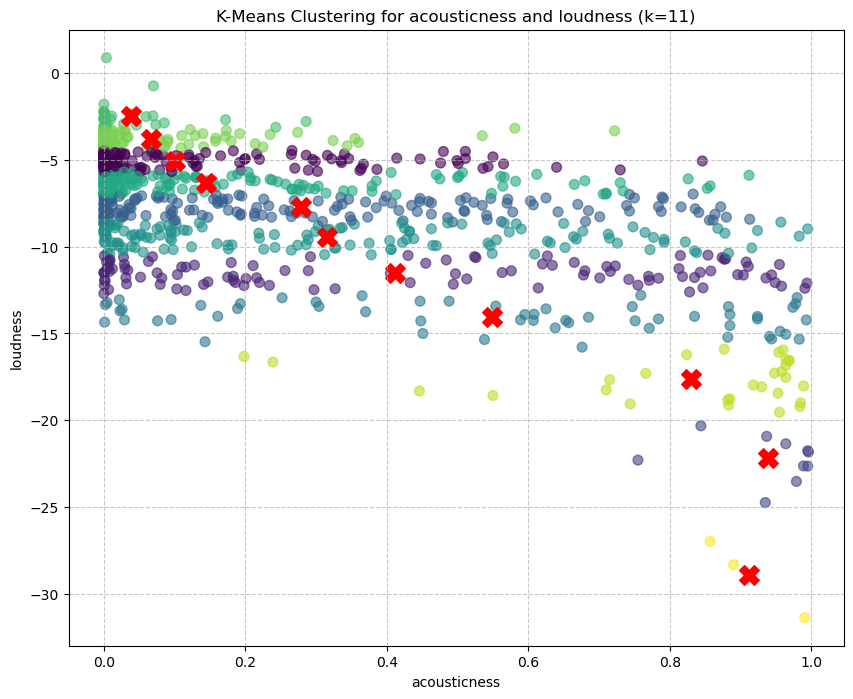

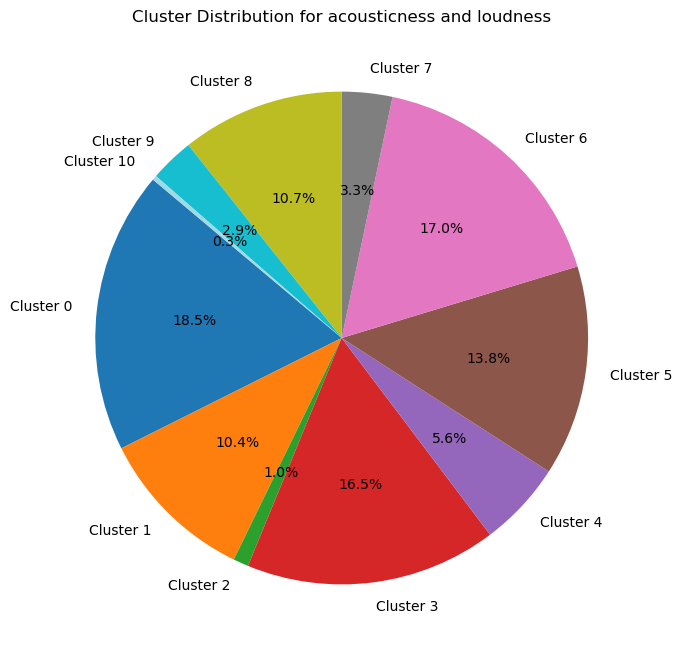

In [235]:
cluster_visualizer.plot_clusters(['acousticness', 'loudness'], k=11)

# Reflection

The initial step of choosing a dataset wasn’t too difficult for me since I knew I wanted to do a project that used music in some way. The main challenges came from using the machine learning models and visualizing the data at each step of the project.

In Part 1, I started by using the pandas correlation matrix, but didn’t like how it looked visually. I went back to my notes and found that the seaborn heatmap looked more appealing and used that instead. This taught me the importance of the visualization of graphs and data presentation. Also, when plotting the pie chart, I had repeat colors next to each other. I looked up the documentation for matplotlib to figure out how I could fix this, and learned how to customize my plots to make them clearer and more visually engaging.

After completing Part 3, my belief was confirmed that genre classification is too difficult to accomplish since most of the classification machine learning models stood around a 50% accuracy, solely based on numerical features, since there are so many overlapping characteristics between genres. This makes it hard to distinguish between music genres, even for a human listener. 
Another challenge during part 3 was implementing all of the models into my code. I knew of the models from labs, however, I decided to do some research and find out how to exactly implement each model and use the feature extractor.

One of the areas I want to focus on improving is how I display and format visualizations. I’d like to better present graphs, learn how to format subplots more efficiently, and explore ways to enhance the clarity and impact of the visual output.

If I had more time, I would have liked to further explore clustering algorithms and try to match the resulting clusters to specific genres in the original dataset. This could provide more insight into how the model is grouping songs, potentially uncovering patterns that aren't immediately obvious. Additionally, I would aim to arrange all my graphs as subplots as I only made one graph a subplot, to make it easier to compare the results side by side and avoid scrolling between multiple figures.

Overall, this project has been a valuable learning experience, especially in terms of visualizing data effectively and understanding the complexities involved in genre classification and machine learning models.



# References

- Reference listPurushottam Malgi (2021). Music Genre Classification. [online] Kaggle.com. Available at: https://www.kaggle.com/datasets/purumalgi/music-genre-classification/data.
- Readthedocs.io. (2025). XGBoost -Documentation — xgboost 3.0.0 documentation. [online] Available at: https://xgboost.readthedocs.io/en/release_3.0.0/.scikit learn (2018).
- 1.4. Support Vector Machines. [online] Scikit-learn.org. Available at: https://scikit-learn.org/stable/modules/svm.html.
- scikit-learn. (n.d.). sklearn.metrics.pairwise.cosine_similarity. [online] Available at: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html.
- w3schools (n.d.). Python Machine Learning - Logistic Regression. [online] Available at: https://www.w3schools.com/python/python_ml_logistic_regression.asp.